Reference: Piasecka, E. et al. Natural variation in the parameters of innate immune cells is preferentially driven by genetic factors resource. Nat. Immunol. 19, 302-314 (2018). Piasecka, B. et al. Distinctive roles of age, sex, and genetics in shaping transcriptional variation of human immune responses to microbial challenges. Proc. Natl. Acad. Sci. 115, E488-E497 (2018). и http://www.milieuinterieur.fr/

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import warnings
import numpy as np
warnings.filterwarnings("ignore")
%matplotlib inline

Данный датасет представляет собой рнк-секвенирование иммуного ответа пациентов на различные стимулы  (Escherichia coli, BCG, Staphylococcus aureus, SEB, Candida albicans and Influenza virus). В данном исследование были секвенированы 560 генов. Основная задача - оценить, насколько может быть вариабелен иммунный ответ в рамках популяции (пусть даже выборка тут небольшая)

Первые колонки, которые в своем названии содержат MFI - это не гены, это усредненный показатель наличиние антитела Н в популяции клеток К. Например, CD38_MFI_in_Bcells  показывает уровень CD38 в B-лимфоцитах. Данные показатели и будут показывать "уровень" имунного ответа. Чем больше этот показатель - тем больше клеток такого типа мы наблюдаем. 
В данной работе мы сосредоточимся на следующийх генах - IFNA2 (возраст) IFNG(возраст),  MAPK14, GATA3

In [2]:
dt = pd.read_csv('dataset_merged.txt',sep='\t')
dt.head()

Проведем небольшую разминку - построим графики, посмотрим на распределения, проведем тесты, посчитаем статистики. 

У нас есть дополнительная информация. Самые интересные из колонок:
 - Age
 - PhysicalActivity
 - Sex
 - MetabolicScore
 - HoursOfSleep
 - UsesCannabis
 - Smoking
 - BMI

 Посмотрим на распределение возрастов и пола

In [3]:
metadata_columns = ['id','Age','PhysicalActivity','Sex','MetabolicScore','BMI','HoursOfSleep','UsesCannabis',\
                    'Smoking','Employed','Education','DustExposure']
ids_description  = dt.drop_duplicates('id').drop(['stimulus'],axis=1)[metadata_columns]
ids_description.head()

,id,Age,PhysicalActivity,Sex,MetabolicScore,BMI,HoursOfSleep,UsesCannabis,Smoking,Employed,Education,DustExposure
0,2,22.33,3.0,Female,0,20.13,9.00,No,Never,No,PhD,No
7,3,28.83,0.0,Female,1,21.33,7.05,No,Active,Yes,Baccalaureat,No
14,4,23.67,0.0,Female,2,22.18,6.50,Yes,Active,Yes,Baccalaureat,Current
21,5,21.17,0.5,Female,0,18.68,10.00,No,Never,No,PhD,No
28,8,26.17,1.5,Female,1,29.01,9.00,No,Never,Yes,Baccalaureat,No


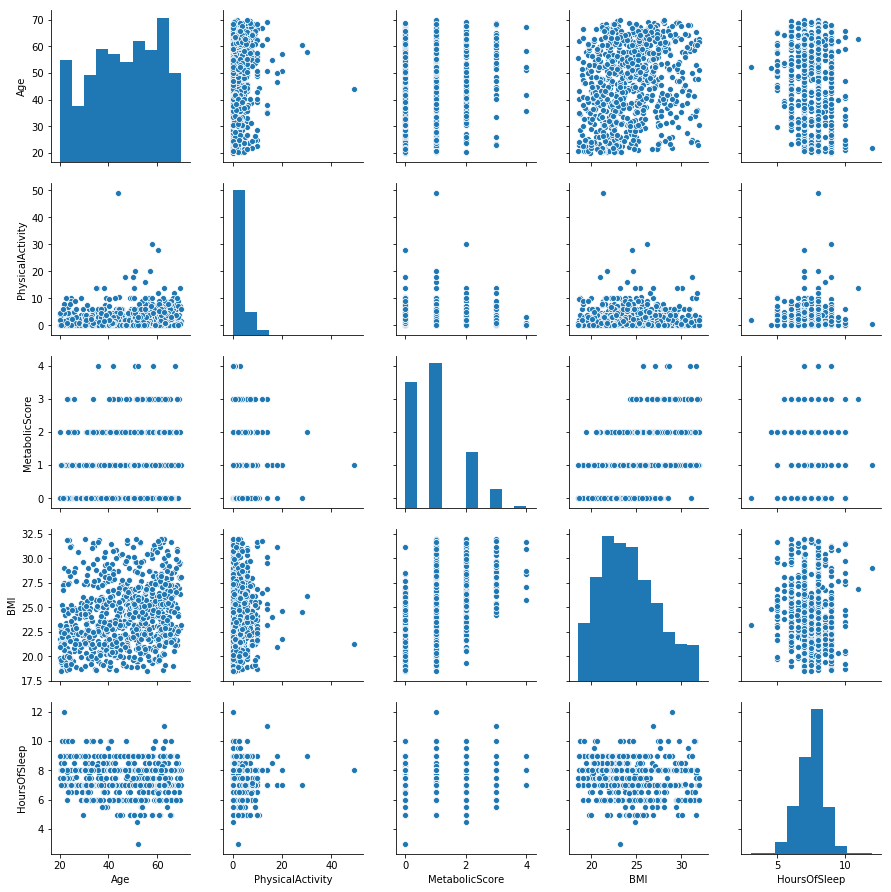

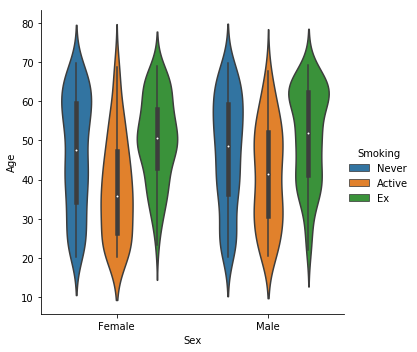

In [20]:
sns.pairplot(ids_description[['Age','PhysicalActivity','MetabolicScore','BMI','HoursOfSleep']]);
plt.show()
sns.catplot(x="Sex", y="Age", hue="Smoking",data=ids_description,kind="violin");

В принципе, данные довольно сбалансированные. Не удивительно, ведь авторы исследования так и пытались сделать. 
Теперь начнем смотреть на экспрессии генов и их связь с возрастом\полом\статусом.

3.1 Сравнение экспресии IFNG у мужчин и женщин

3.1.1 Рассмотрим распределение экспресси IFNG у женщин (со стимулом - S.aureus). На что похоже это распределение? Как это проверить? 

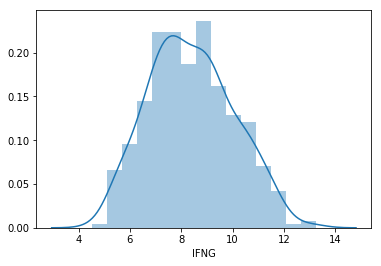

In [6]:
mask = (dt['Sex']=='Female') & (dt['stimulus']=='S.aureus')
sns.distplot(dt.loc[mask,'IFNG']);

Какое удивительное нормальные распределение! Давайте проверим, что оно нормальное

p value 0.8169705867767334


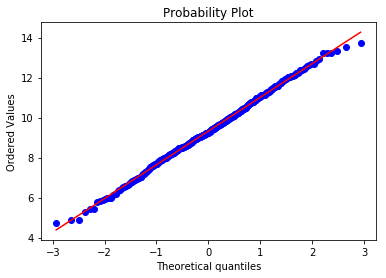

In [21]:
k2, p = sc.stats.shapiro(dt.loc[mask,'IFNG'].values)
print('p value {}'.format(p))
sc.stats.probplot(dt.loc[mask,'IFNG'].values,plot=plt);

 Оценим параметры этого распределения.

In [9]:
d_var = np.var(dt.loc[mask,'IFNG'].values)
d_mean = np.mean(dt.loc[mask,'IFNG'].values)
print('mean {}, var {}'.format(d_mean, d_var))

mean 8.38686991239565, var 2.6778212676547954


Задача 1. Сделать аналогичные шаги для мужчин (со стимулом - S.aureus)

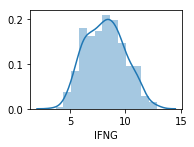

p value 0.008007435128092766
mean 8.169332888011015, var 3.049249527483538


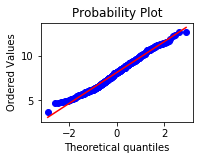

In [35]:
#Task 1 solution
ax1 = plt.subplot(221)
mask = (dt['Sex']=='Male') & (dt['stimulus']=='S.aureus')
sns.distplot(dt.loc[mask,'IFNG'],ax=ax1);
plt.show();
k2, p = sc.stats.shapiro(dt.loc[mask,'IFNG'].values)
print('p value {}'.format(p))
d_var = np.var(dt.loc[mask,'IFNG'].values)
d_mean = np.mean(dt.loc[mask,'IFNG'].values)
#Funny fact - outliers ruin normaltest?
ax2 = plt.subplot(223)
sc.stats.probplot(dt.loc[mask,'IFNG'].values, plot=plt);
print('mean {}, var {}'.format(d_mean, d_var))

Задача 2. Давайте используем бустреп чтобы оценить доверительный интервал для среднего уровня экспресии гена
GATA3 у мужчин и женщин. Используем 1000 итераций, будем семплить по 100 точек. Давайте условимся, что в этот раз работаем со стимулом E.coli

Boostrap for Male
for Male, 95.0 confidence interval 9.142300256634487 and 9.164014458247093
Boostrap for Female
for Female, 95.0 confidence interval 9.316961622151709 and 9.337696682015032


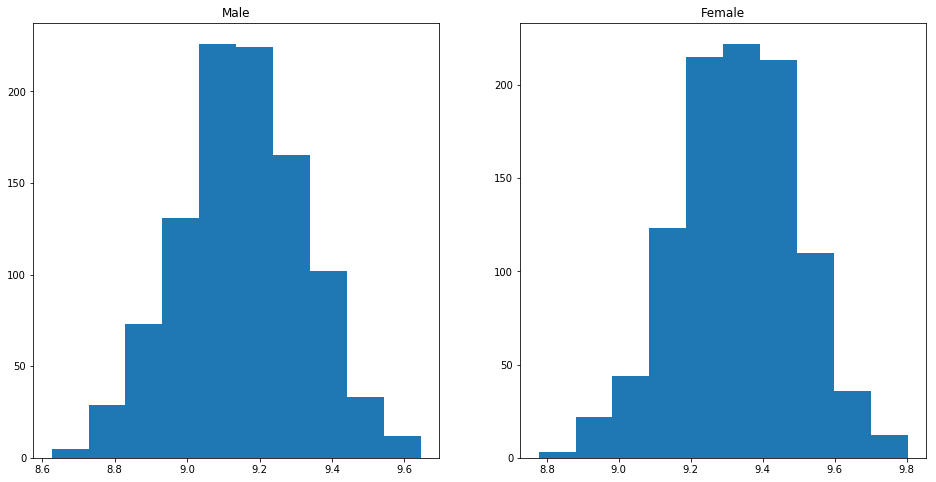

In [40]:
#Task 2 solution
stats = {'Male':list(),'Female':list()}
n_iterations = 1000
n_size = 100
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sc.stats.sem(a)
    h = se * sc.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
f, ax = plt.subplots(1, 2, figsize=(16, 8))
for idx, sex in enumerate(['Male', 'Female']):
    print('Boostrap for {}'.format(sex))
    mask = (dt['Sex']==sex) & (dt['stimulus']=='E.coli')
    values_expression = dt.loc[mask,'IFNG'].values
    for i in range(n_iterations):
    # prepare train and test sets
        sample = np.random.choice(values_expression, size=n_size, replace=True)
        stats[sex].append(np.mean(sample))
    ax[idx].hist(stats[sex]);
    ax[idx].set_title(sex)
    m, l, h = mean_confidence_interval(stats[sex])
    alpha = 0.95
    print('for {}, {} confidence interval {} and {}'.format(sex, alpha*100, l, h))

Выглядит так, будто экспрессия и правда различна. Давайте посмотрим на совместное распределение. В этом нам поможет violin plot

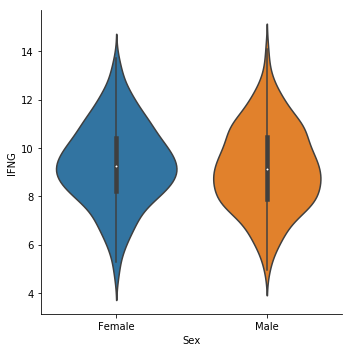

In [12]:
dt_subset = dt.loc[dt['stimulus']=='E.coli',:]
sns.catplot(x="Sex", y="IFNG", kind="violin", data=dt_subset);

Сложно сказать однозначно... Что тут можно сделать? 

Задача 3. Проверим, является ли различие в средней экспресии IFNG у мужчин и женщин при E.coli статистически значимым.
Каким тестом тут лучше воспользоваться и почему?  (при уровне значимости $\alpha  = 0.05$)

In [13]:
#Task 3 solution
_, pval = sc.stats.ttest_ind(dt_subset.loc[(dt_subset['Sex']=='Male'),'IFNG'],
                             dt_subset.loc[(dt_subset['Sex']=='Female'),'IFNG'])
print('pvalue is {}'.format(pval))
if pval < 0.05 :
    print('Yeap')
else:
    print('Nope')

pvalue is 0.15696511170328747
Nope


Задача 4. А интересно, у скольки еще генов различие в средней экспресии у мужчин и женщин при E.coli статистически значимым (при уровне значимости $\alpha  = 0.05$). Не будем усложнять себе жизнь и воспользуемся поправкой Бонферрони

In [14]:
#Task 4 solution
from statsmodels.sandbox.stats.multicomp import multipletests
gene_lists = dt_subset.columns.values[210:-1]
pvals_list = []
for gene in gene_lists:
    _, pval = sc.stats.ttest_ind(dt_subset.loc[dt_subset['Sex']=='Male', gene], dt_subset.loc[dt_subset['Sex']=='Female', gene])
    pvals_list.append(pval)
p_adjusted = multipletests(pvals_list, method='bonferroni')[1]
passed_genes = sum(p_adjusted<0.05)
print('{} genes are different between males and females.'.format(passed_genes))

231 genes are different between males and females.


Отлично, но вернемся к IFNG. Добавим к рассмотрниею следующие параметры - Age, PhysicalActivity, BMI, Smoking, Education, LivesWithPartner. Как можно заметить, некоторые из них категориальные, некоторые - числовые. Тем интересней!

Задача 5. Рассмотрите уровень экспресии IFNG (при E.coli)  в зависимости от каждого из вышеназванных параметров. 
Какой вывод можно сделать? А если дополнительно разбить с учетом пола? 

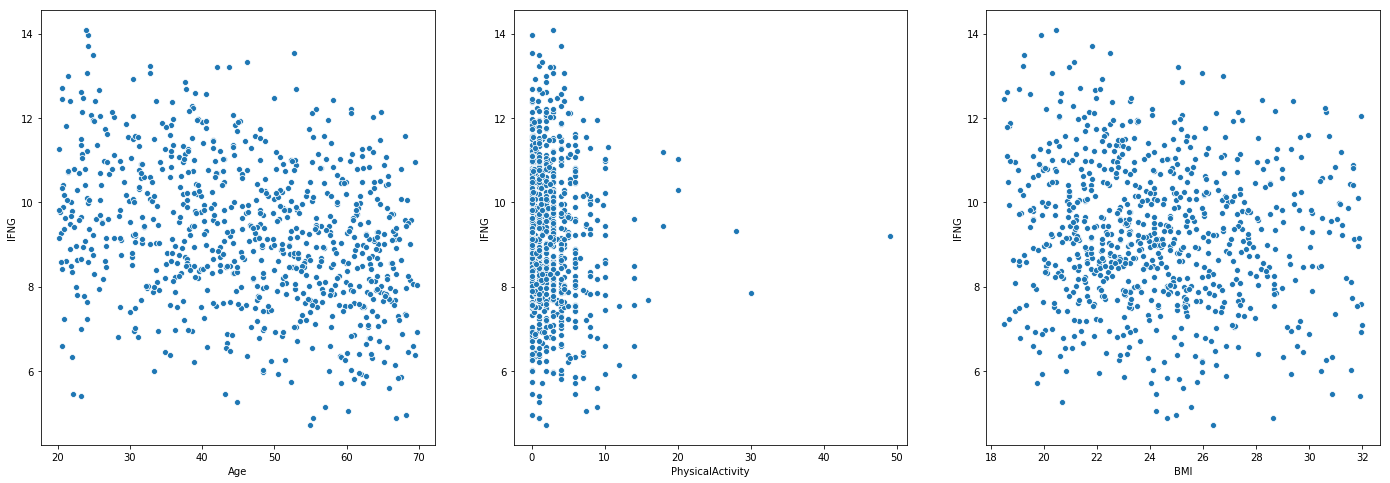

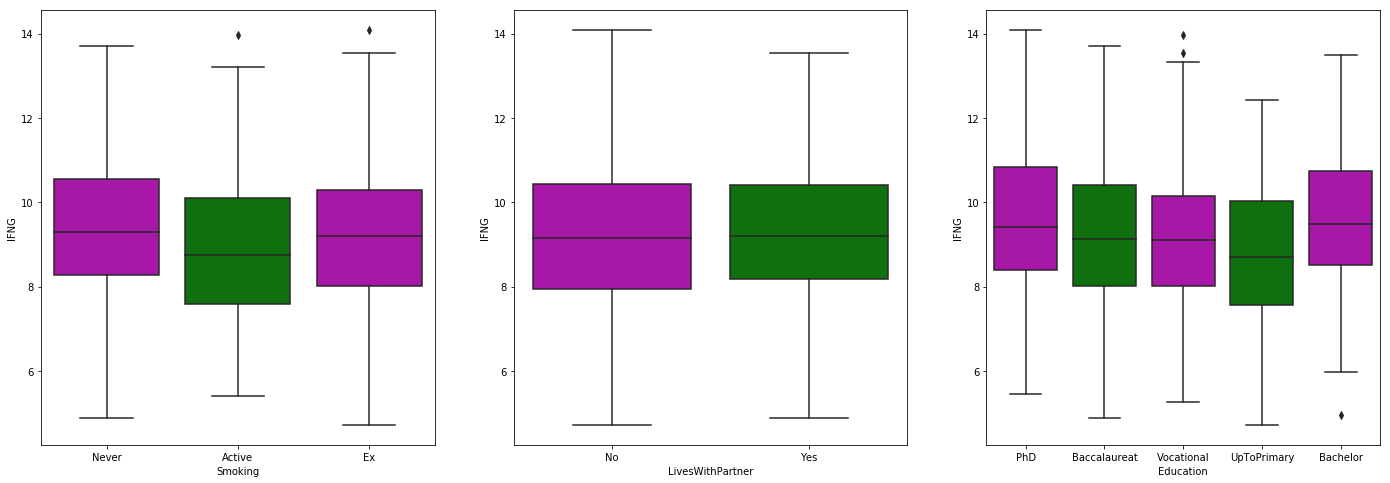

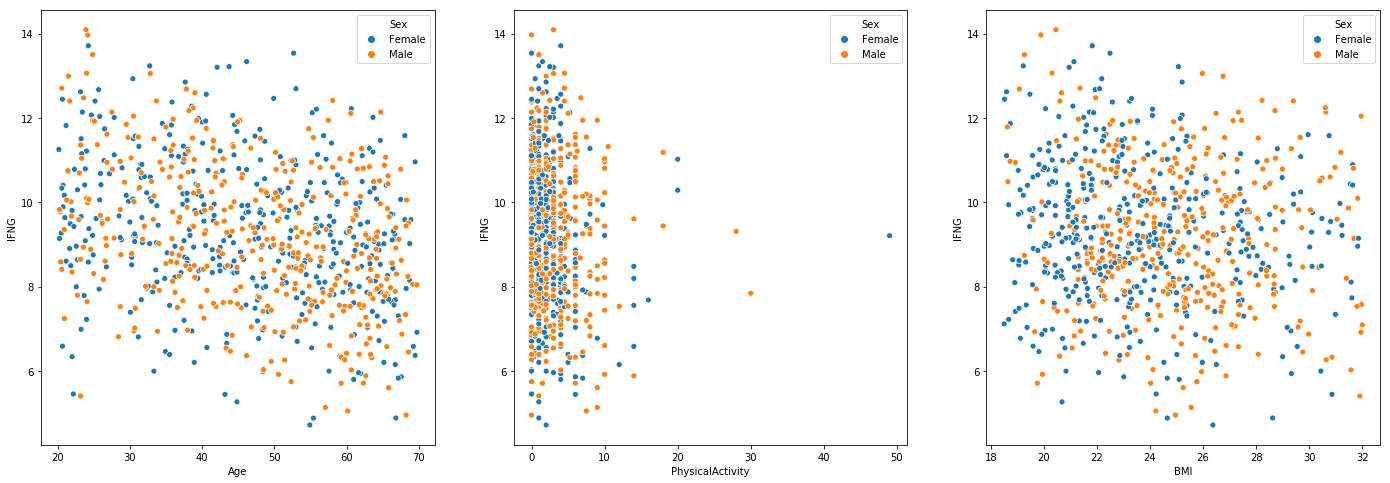

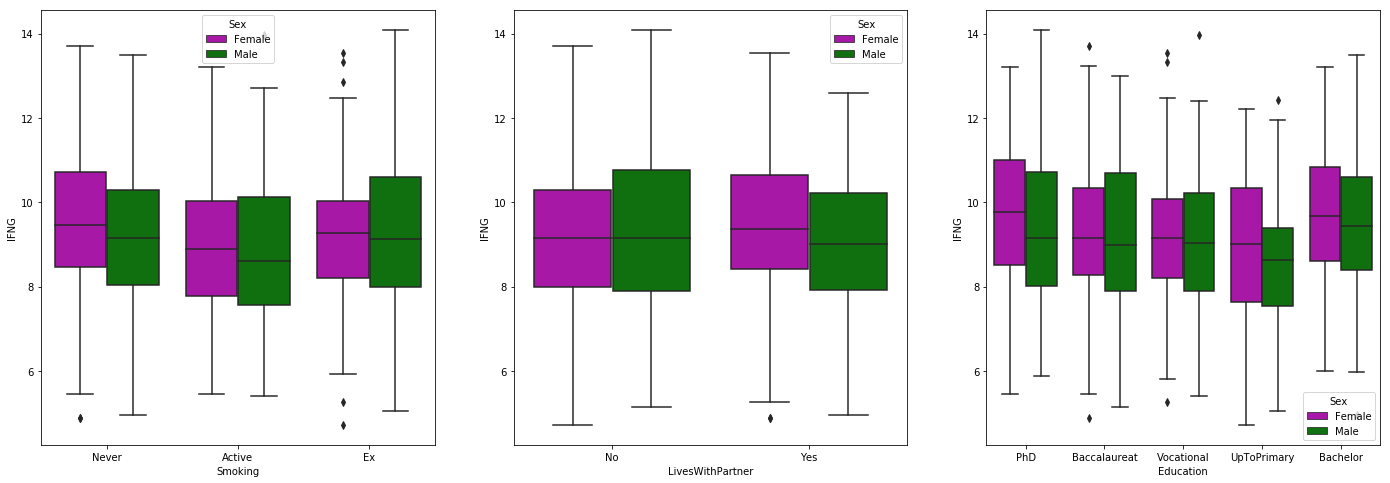

In [15]:
#Task 5 solution
fontsize=18
subset_data = dt.loc[dt['stimulus']=='E.coli', ['Age','PhysicalActivity','BMI','Smoking','Sex',
                                                'LivesWithPartner','Education', 'IFNG']]
# Plot sepal with as a function of sepal_length across days
numeric_columns  = ['Age','PhysicalActivity','BMI']
cat_columns  = ['Smoking','LivesWithPartner','Education']
f, ax = plt.subplots(1, len(numeric_columns), figsize=(24, 8))
for idx, numberic_col in enumerate(numeric_columns):
    sns.scatterplot(x=numberic_col, y="IFNG", data=subset_data, ax=ax[idx])
plt.show()

f, ax = plt.subplots(1, len(cat_columns), figsize=(24, 8))    
for idx, cat_col in enumerate(cat_columns):
    sns.boxplot(x=cat_col, y="IFNG", palette=["m", "g"],
            data=subset_data, ax=ax[idx])
plt.show()    

f, ax = plt.subplots(1, len(numeric_columns), figsize=(24, 8))
for idx, numberic_col in enumerate(numeric_columns):
    g = sns.scatterplot(x=numberic_col, y="IFNG", hue="Sex", data=subset_data, ax=ax[idx])
plt.show()

f, ax = plt.subplots(1, len(cat_columns), figsize=(24, 8))      
for idx, cat_col in enumerate(cat_columns):
    g = sns.boxplot(x=cat_col, y="IFNG",
            hue="Sex", palette=["m", "g"],
            data=subset_data, ax=ax[idx])
plt.show()

Задача 6. Для того, чтобы рассматривать экспрессию между несколькими группами, нам понадобится знание диспресионного анализа. 
Проверьте, можем ли мы утверждать, что уровень экспресии IFNG не зависит от курения (без разбиения по полу) (используейте пакет $statsmodels$). Дополнительно проведите Tukey hsd чтобы оценить разницу между группами

In [16]:
#Task 6 solution
f_value, p_value = sc.stats.f_oneway(subset_data.loc[subset_data['Smoking']=='Never','IFNG'].values,
                                     subset_data.loc[subset_data['Smoking']=='Active','IFNG'].values, 
                                     subset_data.loc[subset_data['Smoking']=='Ex','IFNG'].values)
print('One way anove p value {}'.format(p_value))
from statsmodels.stats.multicomp import pairwise_tukeyhsd
print(pairwise_tukeyhsd(subset_data['IFNG'], subset_data['Smoking']))

One way anove p value 0.013850418823482822
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
Active   Ex    0.2904   -0.123 0.7039 False 
Active Never   0.4587   0.0893 0.8281  True 
  Ex   Never   0.1682  -0.1618 0.4983 False 
--------------------------------------------


В последующих шагах по постараемся воспроизвести основные результаты статьи  Piasecka, E. et al. Natural variation in the parameters of innate immune cells is preferentially driven by genetic factors resource. Nat. Immunol. 19, 302-314 (2018), опубликованной в Nature Genetics. Далее мы работаем с стимулом NS, то есть с изначальным иммуным ответом.

In [70]:
dt_ns  = dt.loc[dt['stimulus']=='NS',:]

Большое Задание 1. Рассмотрите зависимости между предложенными негентическими переменными в этом датасете. Для это сделаете попарные линейные модели и в качестве зависимости возьмите $R^2$. При работе с категориальными переменными, используйте OHE стратегию и используйте их только как предикторы. (Хотя в случае бинарного лейбла можно сделать логрегрессию)

In [44]:
nongenetic_columns = ['Age', 'OwnsHouse',
                      'PhysicalActivity', 'Sex', 'LivesWithPartner', 'LivesWithKids',
                      'BornInCity', 'Inbreeding', 'BMI', 
                      'MetabolicScore', 'LowAppetite', 'TroubleConcentrating',
                      'TroubleSleeping', 'HoursOfSleep', 'Listless', 'UsesCannabis',
                      'RecentPersonalCrisis', 'Smoking', 'Employed', 'Education',
                      'DustExposure', 'Income',
                      'DepressionScore', 'HeartRate',
                      'Temperature']


In [157]:
#Big task solution 1
import itertools
from sklearn import linear_model
#make combinations of feature-outcome
combinations =  list(itertools.permutations(nongenetic_columns, 2))
#make zero matrix for results
dep_matrix = np.zeros((len(nongenetic_columns),len(nongenetic_columns)))
#self-self is 1
np.fill_diagonal(dep_matrix, 1)
idx_columns = dict(zip(nongenetic_columns, np.arange(len(nongenetic_columns))))
#identify which of the columns as categorical
cat_features = []
for col_ in nongenetic_columns:
    vals = dt_ns[col_].value_counts()
    n_features = len(set(vals.index))
    top_5_features = 100*vals.values[:5].sum()/vals.sum()
    print('Feature {}, total features {}, top 5 account for {}'.format(col_,n_features,top_5_features))
    if n_features<=5 or top_5_features>=96:
        cat_features.append(col_)
        print('Can use as category\n')
print('='*50)
print(' '*20+'Making linear regression'+' '*20)
print('='*50)
#columns - predictors (first), rows = dependent (second)
for pair in combinations:
    print(pair)
    if pair[1] in cat_features:
        print('{} is categorical, skip as dependent'.format(pair[1]))
        continue
    if pair[0] in cat_features:
        print('{} is categorical, making dummy variables'.format(pair[0]))
        X = pd.get_dummies(dt_ns[pair[0]].astype(object))
        y = dt_ns[pair[1]]
        reg = linear_model.LinearRegression().fit(X, y)
        r_squared = reg.score(X,y)
        dep_matrix[idx_columns[pair[1]],idx_columns[pair[0]]] = r_squared
    else:
        print('{} is numeric'.format(pair[0]))
        X = dt_ns[pair[0]].values.reshape(-1, 1)
        y = dt_ns[pair[1]].values
        reg = linear_model.LinearRegression().fit(X, y)
        r_squared = reg.score(X,y)
        dep_matrix[idx_columns[pair[1]],idx_columns[pair[0]]] = r_squared

Feature Age, total features 436, top 5 account for 3.2378580323785804
Feature OwnsHouse, total features 2, top 5 account for 100.0
Can use as category

Feature PhysicalActivity, total features 57, top 5 account for 59.40224159402241
Feature Sex, total features 2, top 5 account for 100.0
Can use as category

Feature LivesWithPartner, total features 2, top 5 account for 100.0
Can use as category

Feature LivesWithKids, total features 2, top 5 account for 100.0
Can use as category

Feature BornInCity, total features 2, top 5 account for 100.0
Can use as category

Feature Inbreeding, total features 803, top 5 account for 0.6226650062266501
Feature BMI, total features 455, top 5 account for 3.8605230386052303
Feature MetabolicScore, total features 5, top 5 account for 100.0
Can use as category

Feature LowAppetite, total features 4, top 5 account for 100.0
Can use as category

Feature TroubleConcentrating, total features 4, top 5 account for 100.0
Can use as category

Feature TroubleSleepin

('BornInCity', 'Inbreeding')
BornInCity is categorical, making dummy variables
('BornInCity', 'BMI')
BornInCity is categorical, making dummy variables
('BornInCity', 'MetabolicScore')
MetabolicScore is categorical, skip as dependent
('BornInCity', 'LowAppetite')
LowAppetite is categorical, skip as dependent
('BornInCity', 'TroubleConcentrating')
TroubleConcentrating is categorical, skip as dependent
('BornInCity', 'TroubleSleeping')
TroubleSleeping is categorical, skip as dependent
('BornInCity', 'HoursOfSleep')
BornInCity is categorical, making dummy variables
('BornInCity', 'Listless')
Listless is categorical, skip as dependent
('BornInCity', 'UsesCannabis')
UsesCannabis is categorical, skip as dependent
('BornInCity', 'RecentPersonalCrisis')
RecentPersonalCrisis is categorical, skip as dependent
('BornInCity', 'Smoking')
Smoking is categorical, skip as dependent
('BornInCity', 'Employed')
Employed is categorical, skip as dependent
('BornInCity', 'Education')
Education is categorical

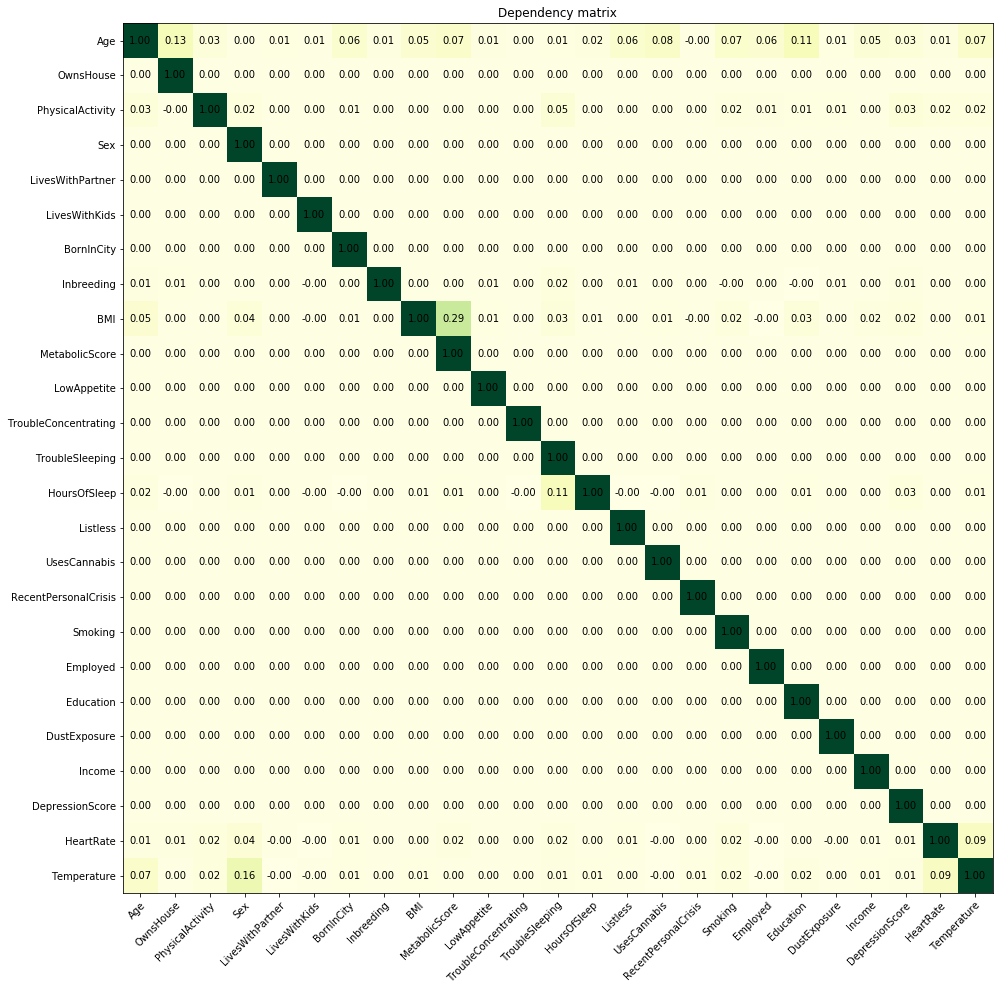

In [172]:
f, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(dep_matrix, cmap="YlGn");
ax.set_xticks(np.arange(len(nongenetic_columns)));
ax.set_yticks(np.arange(len(nongenetic_columns)));
# ... and label them with the respective list entries
ax.set_xticklabels(nongenetic_columns);
ax.set_yticklabels(nongenetic_columns);
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
for i in range(len(nongenetic_columns)):
    for j in range(len(nongenetic_columns)):
        text = ax.text(j, i, '%.2f' % dep_matrix[i, j],
                       ha="center", va="center", color="k")

ax.set_title("Dependency matrix")
fig.tight_layout()
plt.show()